# Modeling with StatsModels

## 1. Ordinary Least Square
- Column Names
- Log Transformation
- Condition Number
- Standard Scaling

# 2. Dimensionality Reduction
- ANOVA
- F-test and Feature Influence

# 3. Outlier
- Cook's Distance

# 4. Regularization
- Lasso

# 5. Diagnosis of Regression
- Residual Normality Test
- Partial Regression Plot

# 6. Cross Validatoin

# 7. Test
- score

In [25]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('./github/code/data/train_macro6.csv', index_col=0, parse_dates=['timestamp'])
df_test_macro = pd.read_csv('./github/code/data/test_macro6.csv', index_col=0, parse_dates=['timestamp'])

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

# 1. Column Names
## Column Names
Replace -, +, :, ~, * in column name with underscore

In [28]:
df_train_macro.reset_index().tail(1)

,index,_timestamp,_full_sq,_life_sq,_floor,_max_floor,_material,_build_year,_num_room,_kitch_sq,_state,_product_type,_area_m,_raion_popul,_green_zone_part,_indust_part,_children_preschool,_preschool_quota,_preschool_education_centers_raion,_children_school,_school_quota,_school_education_centers_raion,_school_education_centers_top_20_raion,_hospital_beds_raion,_healthcare_centers_raion,_university_top_20_raion,_sport_objects_raion,_additional_education_raion,_culture_objects_top_25,_culture_objects_top_25_raion,_shopping_centers_raion,_office_raion,_thermal_power_plant_raion,_incineration_raion,_oil_chemistry_raion,_radiation_raion,_railroad_terminal_raion,_big_market_raion,_nuclear_reactor_raion,_detention_facility_raion,_full_all,_male_f,_female_f,_young_all,_young_male,_young_female,_work_all,_work_male,_work_female,_ekder_all,_ekder_male,_ekder_female,_0_6_all,_0_6_male,_0_6_female,_7_14_all,_7_14_male,_7_14_female,_0_17_all,_0_17_male,_0_17_female,_16_29_all,_16_29_male,_16_29_female,_0_13_all,_0_13_male,_0_13_female,_raion_build_count_with_material_info,_build_count_block,_build_count_wood,_build_count_frame,_build_count_brick,_build_count_monolith,_build_count_panel,_build_count_foam,_build_count_slag,_build_count_mix,_raion_build_count_with_builddate_info,_build_count_before_1920,_build_count_1921_1945,_build_count_1946_1970,_build_count_1971_1995,_build_count_after_1995,_metro_min_avto,_metro_km_avto,_metro_min_walk,_metro_km_walk,_kindergarten_km,_school_km,_park_km,_green_zone_km,_industrial_km,_water_treatment_km,_cemetery_km,_incineration_km,_railroad_station_walk_km,_railroad_station_walk_min,_railroad_station_avto_km,_railroad_station_avto_min,_ID_railroad_station_avto,_public_transport_station_km,_public_transport_station_min_walk,_water_km,_water_1line,_mkad_km,_ttk_km,_sadovoe_km,_bulvar_ring_km,_kremlin_km,_big_road1_km,_big_road1_1line,_big_road2_km,_railroad_km,_railroad_1line,_zd_vokzaly_avto_km,_bus_terminal_avto_km,_oil_chemistry_km,_nuclear_reactor_km,_radiation_km,_power_transmission_line_km,_thermal_power_plant_km,_ts_km,_big_market_km,_market_shop_km,_fitness_km,_swim_pool_km,_ice_rink_km,_stadium_km,_basketball_km,_hospice_morgue_km,_detention_facility_km,_public_healthcare_km,_university_km,_workplaces_km,_shopping_centers_km,_office_km,_additional_education_km,_preschool_km,_big_church_km,_church_synagogue_km,_mosque_km,_theater_km,_museum_km,_exhibition_km,_catering_km,_ecology,_green_part_500,_prom_part_500,_office_count_500,_office_sqm_500,_trc_count_500,_trc_sqm_500,_cafe_count_500,_cafe_sum_500_min_price_avg,_cafe_sum_500_max_price_avg,_cafe_avg_price_500,_cafe_count_500_na_price,_cafe_count_500_price_500,_cafe_count_500_price_1000,_cafe_count_500_price_1500,_cafe_count_500_price_2500,_cafe_count_500_price_4000,_cafe_count_500_price_high,_big_church_count_500,_church_count_500,_mosque_count_500,_leisure_count_500,_sport_count_500,_market_count_500,_green_part_1000,_prom_part_1000,_office_count_1000,_office_sqm_1000,_trc_count_1000,_trc_sqm_1000,_cafe_count_1000,_cafe_sum_1000_min_price_avg,_cafe_sum_1000_max_price_avg,_cafe_avg_price_1000,_cafe_count_1000_na_price,_cafe_count_1000_price_500,_cafe_count_1000_price_1000,_cafe_count_1000_price_1500,_cafe_count_1000_price_2500,_cafe_count_1000_price_4000,_cafe_count_1000_price_high,_big_church_count_1000,_church_count_1000,_mosque_count_1000,_leisure_count_1000,_sport_count_1000,_market_count_1000,_green_part_1500,_prom_part_1500,_office_count_1500,_office_sqm_1500,_trc_count_1500,_trc_sqm_1500,_cafe_count_1500,_cafe_sum_1500_min_price_avg,_cafe_sum_1500_max_price_avg,_cafe_avg_price_1500,_cafe_count_1500_na_price,_cafe_count_1500_price_500,_cafe_count_1500_price_1000,_cafe_count_1500_price_1500,_cafe_count_1500_price_2500,_cafe_count_1500_price_4000,_cafe_count_1500_price_high,_big_church_count_1500,_church_count_1500,_mosque_count_1500,_leisure_count_1500,_sport_count_1500,_market_count_1500,_green_part_2000,_prom_part_2000,_office_count_2000,

In [26]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns.drop('_timestamp')) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

## Log Transformation
Transform data with skewness greater than 1.

In [3]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [4]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     311.7
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:27:33   Log-Likelihood:                -19029.
No. Observations:               30403   AIC:                         3.821e+04
Df Residuals:                   30329   BIC:                         3.882e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               1.523e-05   3.26e-06      4.671      0.000    8.84e-06    2.16e-05
C(_railroad_1line)[T.yes]                                9.03e-05      0.001      0.131      0.896      -0.001       0.001
C(_big_road1_1line)[T.yes]                                -0.0078      0.003     -2.899      0.004      -0.013      -0.003
C(_nuclear_reactor_raion)[T.yes]                          -0.0045      0.001     -4.714      0.000      -0.006      -0.003
C(_water_1line)[T.yes]                                    -0.0074      0.002     -3.625      0.000      -0.011      -0.003
C(_radiation_raion)[T.yes]                                 0.0038      0.002      1.608      0.108      -0.001       0.008
C(_detention_facility_raion)[T.yes]                       -0.0006      0.001     -0.526      0.599      -0.003       0.002
C(_thermal_power_plant_raion)[T.yes]                      -0.0030      0.001     -2.462      0.014      -0.005      -0.001
C(_material)[T.b]                                          0.0114      0.004      2.689      0.007       0.003       0.020
C(_material)[T.c]                                          0.0010      0.003      0.300      0.764      -0.006       0.008
C(_material)[T.d]                                      -2.942e-06   1.73e-05     -0.170      0.865   -3.68e-05    3.09e-05
C(_material)[T.e]                                         -0.0023      0.002     -1.169      0.242      -0.006       0.002
C(_material)[T.f]                                         -0.0111      0.002     -4.770      0.000      -0.016      -0.007
C(_oil_chemistry_raion)[T.yes]                             0.0014      0.001      2.252      0.024       0.000       0.003
C(_incineration_raion)[T.yes]                           5.826e-05      0.001      0.116      0.908      -0.001       0.001
C(_railroad_terminal_raion)[T.yes]                         0.0004      0.001      0.532      0.595      -0.001       0.002
C(_ecology)[T.good]                                       -0.0056      0.002     -3.588      0.000      -0.009      -0.003
C(_ecology)[T.no data]                                     0.0004      0.000      0.880      0.379      -0.000       0.001
C(_ecology)[T.poor]                                        0.0058      0.002      2.340      0.019       0.001       0.011
C(_ecology)[T.satisfactory]                               -0.0002      0.001     -0.102      0.919      -0.003       0.003
C(_big_market_raion)[T.yes]                               -0.0009      0.001     -0.946      0.344      -0.003       0.001
C(_culture_objects_top_25)[T.yes]                          0.0019      0.001      2.193      0.028       0.000       0.004
C(_produ

## Condition Number
Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling
Standalize variables by removing the mean and scaling to unit variance.

In [5]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     37.81
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:30:53   Log-Likelihood:                -18570.
No. Observations:               30403   AIC:                         3.841e+04
Df Residuals:                   29769   BIC:                         4.368e+04
Df Model:                         633                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.2566      0.199     76.660      0.000      14.867      15.647
C(_railroad_1line)[T.yes]                                        -0.0367      0.030     -1.224      0.221      -0.096       0.022
C(_big_road1_1line)[T.yes]                                       -0.0326      0.022     -1.481      0.139      -0.076       0.011
C(_nuclear_reactor_raion)[T.yes]                                  0.1154      0.130      0.887      0.375      -0.140       0.370
C(_water_1line)[T.yes]                                           -0.0258      0.016     -1.596      0.110      -0.057       0.006
C(_radiation_raion)[T.yes]                                       -0.0632      0.061     -1.037      0.300      -0.183       0.056
C(_detention_facility_raion)[T.yes]                              -0.0611      0.091     -0.673      0.501      -0.239       0.117
C(_thermal_power_plant_raion)[T.yes]                             -0.2040      0.131     -1.559      0.119      -0.460       0.052
C(_material)[T.b]                                                -0.0105      0.024     -0.428      0.668      -0.058       0.038
C(_material)[T.c]                                                 0.0121      0.026      0.461      0.645      -0.040       0.064
C(_material)[T.d]                                                 0.1019      0.455      0.224      0.823      -0.791       0.995
C(_material)[T.e]                                                -0.0192      0.027     -0.714      0.475      -0.072       0.033
C(_material)[T.f]                                                -0.0277      0.027     -1.027      0.305      -0.081       0.025
C(_oil_chemistry_raion)[T.yes]                                    0.4192      0.229      1.834      0.067      -0.029       0.867
C(_incineration_raion)[T.yes]                                     0.1995      0.319      0.626      0.532      -0.426       0.825
C(_railroad_terminal_raion)[T.yes]                                0.1232      0.121      1.017      0.309      -0.114       0.361
C(_ecology)[T.good]                                              -0.0020      0.039     -0.051      0.959      -0.078       0.074
C(_ecology)[T.no data]                                            0.3641      0.356      1.024      0.306      -0.333       1.061
C(_ecology)[T.poor]                                              -0.0365      0.026     -1.384      0.166      -0.088       0.015
C(_ecology)[T.satisfactory]                                      -0.0342      0.036     -0.953      0.341      -0.104       0.036
C(_big_market_raion)[T.yes]                                      -0.1892      0.152     -1.24

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction
## ANOVA

In [6]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_railroad_1line),3.039184e-01,1.0,1.498136e+00,2.209681e-01
C(_big_road1_1line),4.447764e-01,1.0,2.192482e+00,1.386963e-01
C(_nuclear_reactor_raion),1.595624e-01,1.0,7.865475e-01,3.751533e-01
C(_water_1line),5.169492e-01,1.0,2.548250e+00,1.104271e-01
C(_radiation_raion),2.183054e-01,1.0,1.076115e+00,2.995767e-01
C(_detention_facility_raion),9.179443e-02,1.0,4.524917e-01,5.011593e-01
C(_thermal_power_plant_raion),4.929411e-01,1.0,2.429905e+00,1.190508e-01
C(_material),1.615288e+00,5.0,1.592481e+00,1.583568e-01
C(_oil_chemistry_raion),6.823442e-01,1.0,3.363549e+00,6.666424e-02
C(_incineration_raion),7.940037e-02,1.0,3.913964e-01,5.315711e-01



We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

## F-test and Feature Influence

In [7]:
result, sms_vars, formula = fs.by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     363.9
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:37:03   Log-Likelihood:                -19729.
No. Observations:               30403   AIC:                         3.957e+04
Df Residuals:                   30346   BIC:                         4.005e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     15.5623      0.004   3545.308      0.000      15.554      15.571
C(_product_type)[T.OwnerOccupier]                              0.1375      0.010     14.227      0.000       0.119       0.156
scale(np.log(_full_sq))                                        0.2757      0.004     70.338      0.000       0.268       0.283
scale(_num_room)                                              -0.1305      0.012    -10.985      0.000      -0.154      -0.107
scale(_state)                                                 -0.1619      0.013    -12.200      0.000      -0.188      -0.136
scale(np.log(_build_count_slag))                              -0.0118      0.005     -2.573      0.010      -0.021      -0.003
scale(np.log(_green_zone_km))                                 -0.0081      0.003     -2.848      0.004      -0.014      -0.003
scale(_ID_railroad_station_avto)                              -0.0120      0.003     -3.624      0.000      -0.018      -0.005
scale(np.log(_ttk_km))                                         0.0445      0.009      4.772      0.000       0.026       0.063
scale(_big_road2_km)                                           0.0255      0.004      5.863      0.000       0.017       0.034
scale(np.log(_zd_vokzaly_avto_km))                             0.0787      0.015      5.351      0.000       0.050       0.108
scale(np.log(_hospice_morgue_km))                              0.0101      0.004      2.610      0.009       0.003       0.018
scale(np.log(_additional_education_km))                       -0.0202      0.004     -5.444      0.000      -0.028      -0.013
scale(np.log(_cafe_count_500))                                 0.0313      0.005      5.858      0.000       0.021       0.042
scale(np.log(_cafe_count_500_price_1500))                     -0.0363      0.008     -4.304      0.000      -0.053      -0.020
scale(np.log(_cafe_count_500_price_2500))                     -0.0132      0.004     -3.010      0.003      -0.022      -0.005
scale(np.log(_cafe_count_1000_price_high))                     0.0134      0.005      2.780      0.005       0.004       0.023
scale(np.log(_office_sqm_1500))                               -0.0244      0.004     -5.517      0.000      -0.033      -0.016
scale(_cafe_sum_1500_min_price_avg)                         -274.0620     97.546     -2.810      0.005    -465.256     -82.868
scale(_cafe_sum_1500_max_price_avg)                         -415.2998    147.799     -2.810      0.005    -704.992    -125.608
scale(_cafe_avg_price_1500)                                  686.1972    244.219      2.810      0.005     207.518    1164.876
scale(np.log(_prom_part_2000))     

# 3. Outlier
## Cook's Distance
- Find data with large leverage and residual by calculating Cook's distance.

In [8]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = pp.remove_outliers(df_train_macro, formula, repeat=3)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     3416.
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:37:48   Log-Likelihood:                 13370.
No. Observations:               26759   AIC:                        -2.663e+04
Df Residuals:                   26702   BIC:                        -2.616e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     15.7563      0.002   9749.201      0.000      15.753      15.759
C(_product_type)[T.OwnerOccupier]                             -0.0854      0.003    -25.460      0.000      -0.092      -0.079
scale(np.log(_full_sq))                                        0.2867      0.001    212.026      0.000       0.284       0.289
scale(_num_room)                                              -0.0911      0.004    -21.270      0.000      -0.099      -0.083
scale(_state)                                                 -0.1317      0.004    -29.317      0.000      -0.140      -0.123
scale(np.log(_build_count_slag))                              -0.0236      0.002    -14.783      0.000      -0.027      -0.020
scale(np.log(_green_zone_km))                                 -0.0038      0.001     -3.852      0.000      -0.006      -0.002
scale(_ID_railroad_station_avto)                              -0.0132      0.001    -11.589      0.000      -0.015      -0.011
scale(np.log(_ttk_km))                                         0.0573      0.003     17.166      0.000       0.051       0.064
scale(_big_road2_km)                                           0.0189      0.001     12.625      0.000       0.016       0.022
scale(np.log(_zd_vokzaly_avto_km))                             0.0587      0.007      8.553      0.000       0.045       0.072
scale(np.log(_hospice_morgue_km))                              0.0101      0.001      7.516      0.000       0.007       0.013
scale(np.log(_additional_education_km))                       -0.0013      0.001     -1.007      0.314      -0.004       0.001
scale(np.log(_cafe_count_500))                                 0.0392      0.002     21.607      0.000       0.036       0.043
scale(np.log(_cafe_count_500_price_1500))                     -0.0252      0.003     -8.563      0.000      -0.031      -0.019
scale(np.log(_cafe_count_500_price_2500))                     -0.0079      0.001     -5.355      0.000      -0.011      -0.005
scale(np.log(_cafe_count_1000_price_high))                     0.0010      0.002      0.568      0.570      -0.002       0.004
scale(np.log(_office_sqm_1500))                               -0.0131      0.002     -8.685      0.000      -0.016      -0.010
scale(_cafe_sum_1500_min_price_avg)                         -212.0157     33.623     -6.306      0.000    -277.919    -146.112
scale(_cafe_sum_1500_max_price_avg)                         -320.6469     50.846     -6.306      0.000    -420.308    -220.986
scale(_cafe_avg_price_1500)                                  530.0024     84.047      6.306      0.000     365.265     694.740
scale(np.log(_prom_part_2000))     

# 4. Regularization
## Lasso
Find variables with zero coefficient when Lasso regularization is applied.

In [9]:
result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [10]:
sms_vars = []
for idx, coef in enumerate(result_lasso.params):
    if coef ==0:
        continue
    feature = result_lasso.params.index[idx]
    if feature == 'Intercept':
        continue
    startDelPos = feature.find('[')
    endDelPos = feature.find(']')
    feature = feature.replace(feature[startDelPos:endDelPos+1], '')
    sms_vars.append(feature)

In [11]:
formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     6077.
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:38:01   Log-Likelihood:                 16682.
No. Observations:               25155   AIC:                        -3.329e+04
Df Residuals:                   25116   BIC:                        -3.297e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     15.7636      0.001   1.12e+04      0.000      15.761      15.766
C(_product_type)[T.OwnerOccupier]                             -0.1195      0.003    -41.493      0.000      -0.125      -0.114
scale(np.log(_full_sq))                                        0.2837      0.001    242.694      0.000       0.281       0.286
scale(_num_room)                                              -0.0990      0.004    -25.934      0.000      -0.106      -0.092
scale(_state)                                                 -0.1364      0.004    -35.014      0.000      -0.144      -0.129
scale(np.log(_build_count_slag))                              -0.0238      0.001    -17.259      0.000      -0.027      -0.021
scale(np.log(_green_zone_km))                               9.879e-05      0.001      0.121      0.904      -0.002       0.002
scale(_ID_railroad_station_avto)                              -0.0079      0.001     -8.532      0.000      -0.010      -0.006
scale(np.log(_ttk_km))                                         0.0393      0.003     13.962      0.000       0.034       0.045
scale(np.log(_zd_vokzaly_avto_km))                             0.0220      0.006      3.704      0.000       0.010       0.034
scale(np.log(_cafe_count_500))                                 0.0334      0.001     25.844      0.000       0.031       0.036
scale(np.log(_cafe_count_500_price_2500))                     -0.0081      0.001     -6.596      0.000      -0.010      -0.006
scale(_cafe_sum_1500_max_price_avg)                            0.0026      0.001      2.767      0.006       0.001       0.004
scale(np.log(_trc_count_2000))                                 0.0278      0.003      8.014      0.000       0.021       0.035
scale(np.log(_church_count_2000))                              0.0189      0.001     15.937      0.000       0.017       0.021
scale(np.log(_sport_count_2000))                               0.0327      0.002     16.915      0.000       0.029       0.036
scale(np.log(_mosque_count_3000))                             -0.0038      0.001     -3.774      0.000      -0.006      -0.002
scale(_market_count_5000)                                     -0.0249      0.001    -16.718      0.000      -0.028      -0.022
scale(np.log(_rel_floor))                                      0.0169      0.001     19.443      0.000       0.015       0.019
scale(np.log(_avg_price_ID_railroad_station_walk))             0.3548      0.079      4.520      0.000       0.201       0.509
scale(np.log(_avg_price_ID_big_road1))                         0.0351      0.001     24.182      0.000       0.032       0.038
scale(I(_max_floor ** 2))          

# 5. Diagnosis of Regression
## Residual Normality Test

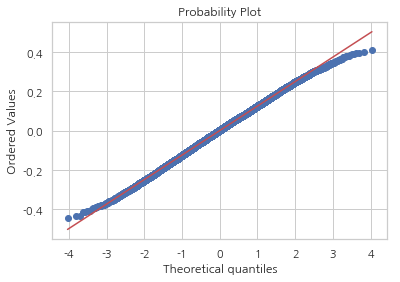

In [12]:
# outlier remove result 
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [13]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 37.811
P-value     :  0.000


# Partial Regression Plot
Let's visualize the influence of a single independent variable.

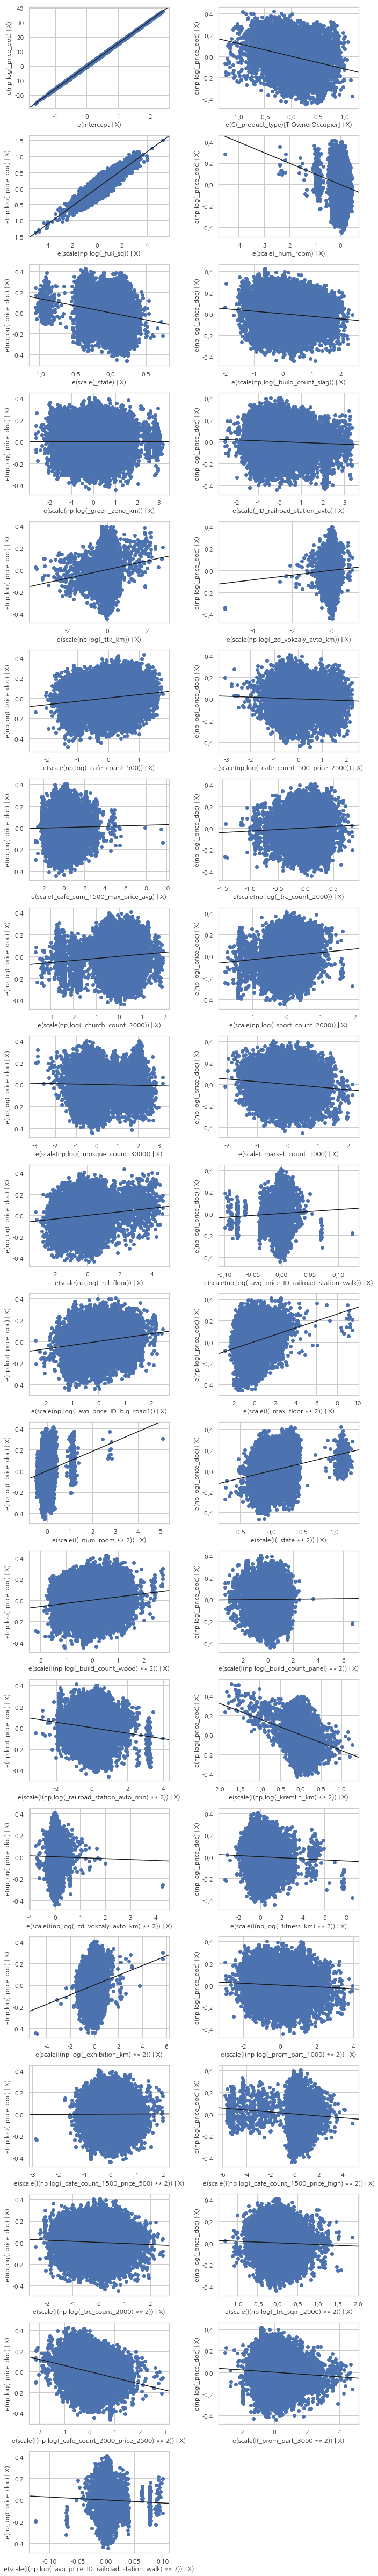

In [14]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# 6. Cross Validation

In [15]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

0.3838209048061246

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  1.,  1.,  3.,
         0.,  1.,  1.,  1.,  0.,  1.,  4.,  0.,  2.,  3.,  1.,  4.,  0.,
         4.,  3.,  5.,  8., 10.,  5.,  5.,  8.,  9., 14.,  9.,  9.,  8.,
        12., 17., 20., 24., 22., 26., 22., 17., 20., 18., 38., 22., 27.,
        32., 23., 32., 28., 28., 29., 22., 27., 34., 20., 28., 20., 21.,
        20., 23., 19., 11., 28., 13., 16., 15., 16.,  9.,  9., 15., 10.,
         6.,  8.,  4.,  6.,  7.,  6.,  2.,  2.,  2.]),
 array([-0.60749884, -0.59286562, -0.57823239, -0.56359917, -0.54896595,
        -0.53433272, -0.5196995 , -0.50506628, -0.49043305, -0.47579983,
        -0.46116661, -0.44653338, -0.43190016, -0.41726694, -0.40263371,
        -0.38800049, -0.37336726, -0.35873404, -0.34410082, -0.32946759,
        -0.31483437, -0.30020115, -0.28556792, -0.2709347 , -0.25630148,
        -0.24166825, -0.22703503, -0.21240181, -0.19776858, -0.183135

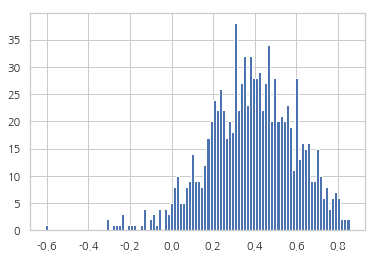

In [16]:
plt.hist(r2s, bins=100)

In [17]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('./data/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

In [19]:
df_test_macro.tail(1)

,_timestamp,_full_sq,_life_sq,_floor,_max_floor,_material,_build_year,_num_room,_kitch_sq,_state,_product_type,_area_m,_raion_popul,_green_zone_part,_indust_part,_children_preschool,_preschool_quota,_preschool_education_centers_raion,_children_school,_school_quota,_school_education_centers_raion,_school_education_centers_top_20_raion,_hospital_beds_raion,_healthcare_centers_raion,_university_top_20_raion,_sport_objects_raion,_additional_education_raion,_culture_objects_top_25,_culture_objects_top_25_raion,_shopping_centers_raion,_office_raion,_thermal_power_plant_raion,_incineration_raion,_oil_chemistry_raion,_radiation_raion,_railroad_terminal_raion,_big_market_raion,_nuclear_reactor_raion,_detention_facility_raion,_full_all,_male_f,_female_f,_young_all,_young_male,_young_female,_work_all,_work_male,_work_female,_ekder_all,_ekder_male,_ekder_female,_0_6_all,_0_6_male,_0_6_female,_7_14_all,_7_14_male,_7_14_female,_0_17_all,_0_17_male,_0_17_female,_16_29_all,_16_29_male,_16_29_female,_0_13_all,_0_13_male,_0_13_female,_raion_build_count_with_material_info,_build_count_block,_build_count_wood,_build_count_frame,_build_count_brick,_build_count_monolith,_build_count_panel,_build_count_foam,_build_count_slag,_build_count_mix,_raion_build_count_with_builddate_info,_build_count_before_1920,_build_count_1921_1945,_build_count_1946_1970,_build_count_1971_1995,_build_count_after_1995,_metro_min_avto,_metro_km_avto,_metro_min_walk,_metro_km_walk,_kindergarten_km,_school_km,_park_km,_green_zone_km,_industrial_km,_water_treatment_km,_cemetery_km,_incineration_km,_railroad_station_walk_km,_railroad_station_walk_min,_railroad_station_avto_km,_railroad_station_avto_min,_ID_railroad_station_avto,_public_transport_station_km,_public_transport_station_min_walk,_water_km,_water_1line,_mkad_km,_ttk_km,_sadovoe_km,_bulvar_ring_km,_kremlin_km,_big_road1_km,_big_road1_1line,_big_road2_km,_railroad_km,_railroad_1line,_zd_vokzaly_avto_km,_bus_terminal_avto_km,_oil_chemistry_km,_nuclear_reactor_km,_radiation_km,_power_transmission_line_km,_thermal_power_plant_km,_ts_km,_big_market_km,_market_shop_km,_fitness_km,_swim_pool_km,_ice_rink_km,_stadium_km,_basketball_km,_hospice_morgue_km,_detention_facility_km,_public_healthcare_km,_university_km,_workplaces_km,_shopping_centers_km,_office_km,_additional_education_km,_preschool_km,_big_church_km,_church_synagogue_km,_mosque_km,_theater_km,_museum_km,_exhibition_km,_catering_km,_ecology,_green_part_500,_prom_part_500,_office_count_500,_office_sqm_500,_trc_count_500,_trc_sqm_500,_cafe_count_500,_cafe_sum_500_min_price_avg,_cafe_sum_500_max_price_avg,_cafe_avg_price_500,_cafe_count_500_na_price,_cafe_count_500_price_500,_cafe_count_500_price_1000,_cafe_count_500_price_1500,_cafe_count_500_price_2500,_cafe_count_500_price_4000,_cafe_count_500_price_high,_big_church_count_500,_church_count_500,_mosque_count_500,_leisure_count_500,_sport_count_500,_market_count_500,_green_part_1000,_prom_part_1000,_office_count_1000,_office_sqm_1000,_trc_count_1000,_trc_sqm_1000,_cafe_count_1000,_cafe_sum_1000_min_price_avg,_cafe_sum_1000_max_price_avg,_cafe_avg_price_1000,_cafe_count_1000_na_price,_cafe_count_1000_price_500,_cafe_count_1000_price_1000,_cafe_count_1000_price_1500,_cafe_count_1000_price_2500,_cafe_count_1000_price_4000,_cafe_count_1000_price_high,_big_church_count_1000,_church_count_1000,_mosque_count_1000,_leisure_count_1000,_sport_count_1000,_market_count_1000,_green_part_1500,_prom_part_1500,_office_count_1500,_office_sqm_1500,_trc_count_1500,_trc_sqm_1500,_cafe_count_1500,_cafe_sum_1500_min_price_avg,_cafe_sum_1500_max_price_avg,_cafe_avg_price_1500,_cafe_count_1500_na_price,_cafe_count_1500_price_500,_cafe_count_1500_price_1000,_cafe_count_1500_price_1500,_cafe_count_1500_price_2500,_cafe_count_1500_price_4000,_cafe_count_1500_price_high,_big_church_count_1500,_church_count_1500,_mosque_count_1500,_leisure_count_1500,_sport_count_1500,_market_count_1500,_green_part_2000,_prom_part_2000,_office_count_2000,_offic

In [18]:
y_pred

,price_doc
0,5.097581e+06
1,8.316486e+06
2,6.086120e+06
3,5.656505e+06
4,5.210282e+06
5,8.640287e+06
6,4.944546e+06
7,4.123123e+06
8,4.641353e+06
9,5.317868e+06


## Score

0.39643